In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import *
import pandas as pd

In [2]:
## Knapmeyer et al. seismic moment values
Mw = [1,2,3,4,5,6,7, 7.6]
M0 = [4e10, 1.3e12, 4e13, 1.3e15, 4e16, 1.3e18, 4e19, 3.2e20]
strongfew  = [38*60, 5.5*60*60, 1.9*24*60*60 , 17.1*24*60*60, 148*24*60*60, 3.6*365.25*24*60*60, 30.3*365.25*24*60*60, 115*365.25*24*60*60]
strongmany = [72, 10.5*60, 1.5*3600, 13.1*60*60]
medium = [48.5*60, 7*60*60, 2.5*24*3600, 21.8*24*3600, 189*24*3600, 4.5*365.25*24*3600]
weakmany = [2.5*3600, 21.9*3600, 7.9*24*3600, 68.5*24*3600]
weakfew = [3.9*24*3600, 33.5*24*3600, 290*24*3600, 6.7*365.25*24*3600, 50*365.25*24*3600, 516*365.25*24*3600, 4500*365.25*24*3600, 17000*365.25*24*3600]


knapmeyer_arr = np.zeros((len(M0), 7))
knapmeyer_arr[:,0] = Mw
knapmeyer_arr[:,1] = M0
knapmeyer_arr[0:len(strongfew),2] = strongfew
knapmeyer_arr[0:len(strongmany),3] = strongmany
knapmeyer_arr[0:len(medium),4] = medium
knapmeyer_arr[0:len(weakfew),5] = weakfew
knapmeyer_arr[0:len(weakmany),6] = weakmany

In [3]:
## Golombek sesimic moments 2002
M0 = np.geomspace(1e10, 1e20, 11)
M0 = np.delete(M0, 1)

mb = np.array([1,2.2,2.8,3.4,4,4.6,5.2,5.8,6.4,7])
Gol_rec_rates19 = np.array([14*60, 3.7*3600, 15*3600, 2.5*24*3600, 9.8*24*3600, 1.3*30*24*3600, 5*30*24*3600, 1.7*365.25*24*3600, 6.7*365.25*24*3600, 27*365.25*24*3600])
Gol_rec_rates18 = np.array([2.4*3600, 37*3600, 6.2*24*3600, 24.7*24*3600, 3.2*30*24*3600, 1.1*365.25*24*3600, 4.3*365.25*24*3600, 17*365.25*24*3600, 68*365.25*24*3600,269*365.25*24*3600])
Gol_rec_rates17 = np.array([1*24*3600, 15*24*3600, 2*30*24*3600, 8.1*30*24*3600, 2.7*365.25*24*3600, 10.7*365.25*24*3600, 43*365.25*24*3600, 170*365.25*24*3600, 678*365.25*24*3600, 2698*365.25*24*3600])
golombek_arr = np.zeros((len(Gol_rec_rates19), 5))
golombek_arr[:,0] = mb
golombek_arr[:,1] = M0
golombek_arr[:,2] = Gol_rec_rates19
golombek_arr[:,3] = Gol_rec_rates18
golombek_arr[:,4] = Gol_rec_rates17

## Golombek sesimic moments 1992
mw = np.array([1.3, 2.2, 3.1, 4, 4.9, 5.8, 6.7])
M0 = np.power(10, np.array([17.5, 19, 20.5, 22, 23.5, 25, 26.5])) * 1e-7
Gol92_rec_rates = np.array([52*24*3600, 1*365.25*24*3600, 9*365.25*24*3600, 71*365.25*24*3600, 565*365.25*24*3600, 4484*365.25*24*3600, 35587*365.25*24*3600])
golombek92_arr = np.zeros((len(Gol92_rec_rates), 3))
golombek92_arr [:,0] = mw
golombek92_arr [:,1] = M0
golombek92_arr [:,2] = Gol92_rec_rates
print(golombek92_arr [:,1])

[3.16227766e+10 1.00000000e+12 3.16227766e+13 1.00000000e+15
 3.16227766e+16 1.00000000e+18 3.16227766e+19]


In [4]:
## Phillips 1991 rates
M0 = np.geomspace(1e14, 1e19, 6)
Phillips_rec_rates_int = np.array([200, 42.8, 9.15, 1.96, 0.42, 0.09])
Phillips_rec_rates = np.cumsum(Phillips_rec_rates_int[::-1])[::-1] 
phillips_arr = np.zeros((len(Phillips_rec_rates_int), 2))
phillips_arr[:,0] = M0
phillips_arr[:,1] = Phillips_rec_rates

## 1. Lithopheric cooling

$T(z) = T_{s} + (T_{m} - T_{s})erf(\frac{z}{(2kt)^.5})$


1. Surface temperatue = 473 deg C ()
2. Mantle temperature = 1450 deg c ()


In [5]:
Ts = 473                      ## in deg C
Tm = 1300                     ## in deg C
Tz = 600                      ## in deg C
kappa = 1*1e-6/3.17098e-8     ## in m2/yr

In [6]:
def halfspacecooling(tzlist):
    t = tzlist[0]
    z = tzlist[1]
    
    Ts = 473
    Tm = 1300
    kappa = 1*1e-6/3.17098e-8            ## 1 mm2/s
    
    T = np.zeros_like(t)
    T = Ts + (Tm-Ts)*erf(z/(2*np.sqrt(kappa*t)))
    
    return T

depth = np.linspace(0, 200e3, 1000)
age = np.linspace(0, 0.5e9, 10000)

t, d = np.meshgrid(age, depth)
T = halfspacecooling([t, d])

/tmp/ipykernel_11169/1403461991.py:10: RuntimeWarning: divide by zero encountered in divide
  T = Ts + (Tm-Ts)*erf(z/(2*np.sqrt(kappa*t)))
/tmp/ipykernel_11169/1403461991.py:10: RuntimeWarning: invalid value encountered in divide
  T = Ts + (Tm-Ts)*erf(z/(2*np.sqrt(kappa*t)))


In [7]:
## cooling rate
Tdot = np.gradient(T, axis = 1, edge_order = 1)
print(Tdot)

[[            nan             nan  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.52772292e+02 -3.87228771e+02 -1.56559173e+01 ... -3.72091978e-05
  -3.72036154e-05 -3.72008246e-05]
 [-6.79480919e+02 -3.61123852e+02 -3.09343389e+01 ... -7.44182537e-05
  -7.44070890e-05 -7.44015074e-05]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.97226262e-02
  -1.97209135e-02 -1.97200571e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.97173905e-02
  -1.97156807e-02 -1.97148259e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.97121114e-02
  -1.97104045e-02 -1.97095511e-02]]


In [13]:
(0-(-.0045)) / 4.5e8

1e-11

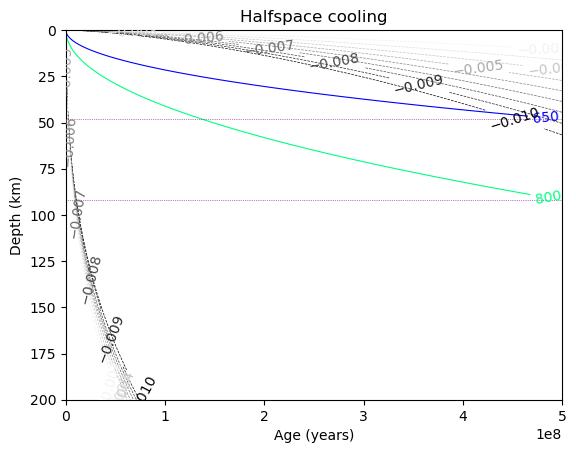

In [8]:
cs = plt.contour(t, d/1e3, T, levels = [650, 800], cmap = "winter", linewidths=0.8)
cs1 = plt.contour(t, d/1e3, Tdot, levels=np.linspace(-0.01, -0.001, 10), cmap="Greys_r", linewidths = 0.5, linestyles = '--')
plt.clabel(cs)
plt.clabel(cs1)
plt.title('Halfspace cooling')
plt.gca().invert_yaxis()
# cbar = plt.colorbar()
# cbar.set_label("Temperature (deg C)")
plt.axhline(48, age[0], age[-1], color='purple', linewidth=0.5, linestyle = ":")
plt.axhline(92, age[0], age[-1], color='purple', linewidth=0.5, linestyle = ":")
plt.xlabel("Age (years)")
plt.ylabel("Depth (km)")
plt.show()

Note: Cooling rate calculated for time intrval of 0.45 Myr.

### 1.1 Strain rate due to lithospheric contraction

In [39]:
def moment2magnitude(m0):
    mw = 2/3 * (np.log10(m0) - 9.1)
    return mw

def moment2surmagnitude(m0):
    ms = np.log10(m0*.001)-19.46
    return ms

def magnitude2moment(mw):
    m0 = np.power(10, (3/2 *mw + 9.1))
    return m0

def cumulative_moment(strain_rate, seis_volume, shear_mod = 70e9, seis_efficiency=1, time = 365.25*24*60*60):
    Mcum = seis_efficiency * strain_rate * seis_volume * shear_mod * time
    return Mcum

def adot_parameter(strainrate, seisvolume, shear_mod = 70e9, m0_max=1e20, beta = 0.67):
    adot = (1-beta)/beta * np.power(m0_max, beta-1) * strainrate * shear_mod * seisvolume 
    return adot

def numevents_year(m0_min, m0_max, adot, beta=0.67):
    numevents = adot * (np.power(m0_min, -beta) - np.power(m0_max, -beta))
    return numevents

## Strain rate computation
1. Banerdt et al. (1986) use shear modulus $mu$ = 50 GPa.
2. Lithosphereic thicckness used: min = 48 km corresponding to 650 deg C isotherm after 500 Myr cooling; max - 130 km corresponding to 800 deg C isotherm after 1 Gyr cooling
3. Planetary radius = 6051.8 km
4. beta value: the exponenet (equivalent of b) in moment relation = 0.67 (find reference / add text from notes)
5. alpha = thermal expansion coefficient - From Phillips 1991 and Knapmeyer 2006
6. cooling rate in K/yr based on plot from above for the past ~0.45 Myr

In [55]:
## strain rate
Ls = 40                ## in km
Rp = 6051.8            ## in km
alpha = 3e-5           ## volumetric thermal expansion coefficient in /K
V = (4/3) * np.pi * Rp**3 - (Rp-Ls)**3
cooling_rate = 1e-9 
shear_mod = 30e9
strainrate_lith =  ((alpha* cooling_rate * V) / (4*np.pi*Ls*(Rp - Ls/2)**2))/(365.25*24*60*60)
print("the strain rate per second is = ", '{:.2e}'.format(strainrate_lith))


## cumulative moment
Mcum = cumulative_moment(strainrate_lith, V*1e9, shear_mod = shear_mod)
print("the cumulative moment is = ", '{:.2e}'.format(Mcum))

the strain rate per second is =  3.70e-20
the cumulative moment is =  2.49e+19


In [48]:
## comparison with Knapmeyer plots
## number of evets / year  - Phillips 1991 values  
num = 11
beta = 0.67          ##(Phillips 1991)
m0_max = magnitude2moment(7)    ## in Nm
m0_min = magnitude2moment(1)
adot = adot_parameter(strainrate_lith, V*1e9, shear_mod = shear_mod, m0_max=m0_max )
m0_range = np.geomspace(m0_min, m0_max, num=11)
m0_min_knapmeyer = 3.98e10 

num_events = []
for mom in m0_range:
    rr = numevents_year(mom, m0_max, adot, beta=0.67)
    num_events.append(rr)
    

events_arr = np.zeros((num, 3))
events_arr[:,0] = moment2magnitude(m0_range)
events_arr[:,1] = m0_range
events_arr[:,2] = np.array(num_events)

In [49]:
# num = 11
# # beta = 0.67          ##(Phillips 1991)
# m0_max = magnitude2moment(7)    ## in Nm
# m0_min = magnitude2moment(1)
# m0_range = np.geomspace(m0_min, m0_max, num=num)
# m0_min_knapmeyer = 3.98e10 

# events_arr = np.zeros((num, 4))
# events_arr[:,0] = moment2magnitude(m0_range)
# events_arr[:,1] = m0_range

# ## strain rate
# Ls = np.array([48,130])                ## in km
# shear_mod = np.array([30e9,70e9])
# Rp = 6051.8            ## in km
# alpha = 3e-5           ## volumetric thermal expansion coefficient in /K


# ## two runs - one for a thin lithopshere and the other for a thick lithosphere
# for i in range(2):
#     V = (4/3) * np.pi * Rp**3 - (Rp-Ls[i])**3
#     cooling_rate = 1e-9 
#     strainrate_lith =  ((alpha* cooling_rate * V) / (4*np.pi*Ls[i]*(Rp - Ls[i]/2)**2))/(365.25*24*60*60)
#     Mcum = cumulative_moment(strainrate_lith, V*1e9, shear_mod = shear_mod[i])
#     adot = adot_parameter(strainrate_lith, V*1e9, shear_mod = shear_mod[i], m0_max=m0_max)
#     for m in range(len(m0_range)):
#         events_arr[m,2+i] = numevents_year(m0_range[m], m0_max, adot, beta=0.67)

/tmp/ipykernel_26174/1339779434.py:3: RuntimeWarning: divide by zero encountered in divide
  ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,3], "o-" , label = "knapmeyer_strongmany", c = "#dfc0eb")
/tmp/ipykernel_26174/1339779434.py:7: RuntimeWarning: divide by zero encountered in divide
  ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,6], "o-" , label = "knapmeyer_weakfew", c = "#c377e0")


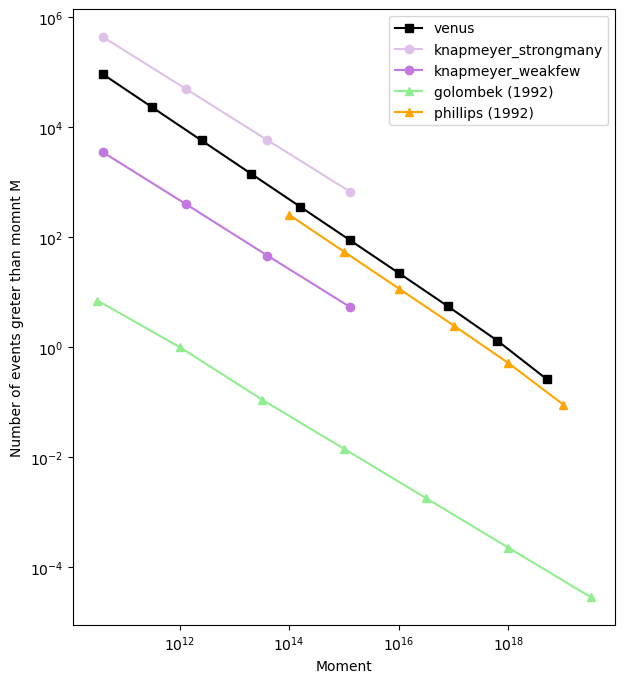

In [50]:
fig, ax = plt.subplots(1,1, figsize=(7,8))
ax.plot(events_arr[:-1,1],(365.25*24*60*60)*events_arr[:-1,2], "s-", label = "venus", c='k')
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,3], "o-" , label = "knapmeyer_strongmany", c = "#dfc0eb")
# ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,2], "o-" , label = "knapmeyer_strongfew", c = "#d5a6e6")
# ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,4], "o-" , label = "knapmeyer_medium", c = "#eddbf4")
# ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,5], "o-" , label = "knapmeyer_weakmany", c = "#cd8de5")
ax.plot(knapmeyer_arr[:,1], (365.25*24*60*60)/knapmeyer_arr[:,6], "o-" , label = "knapmeyer_weakfew", c = "#c377e0")
# ax.plot(golombek_arr[:,1], (365.25*24*60*60)/golombek_arr[:,2], "^-" , label = "golombek (2002)", c= "green")
# ax.plot(golombek_arr[:,1], (365.25*24*60*60)/golombek_arr[:,3], "^-" , label = "golombek (2002)", c= "green")
# ax.plot(golombek_arr[:,1], (365.25*24*60*60)/golombek_arr[:,4], "^-" , label = "golombek (2002)", c= "green")
ax.plot(golombek92_arr[:,1], (365.25*24*60*60)/golombek92_arr[:,2], "^-" , label = "golombek (1992)", c= "lightgreen")
ax.plot(phillips_arr[:,0], phillips_arr[:,1], "^-" , label = "phillips (1992)", c= "orange")
# ax.set_xlim(m0_range[0], m0_range[-1])
ax.set_xscale('log',base=10) 
ax.set_yscale('log',base=10)
ax.legend()
ax.set_xlabel("Moment")
ax.set_ylabel("Number of events greter than momnt M")
plt.show()

## Strain rate due to dynamic uplift and subsidence
Equations from Rudge et al. 2008 (https://www.sciencedirect.com/science/article/pii/S0012821X07007674?via%3Dihub), eq. 2 and Frazer & Korenaga 2022 (https://www.sciencedirect.com/science/article/pii/S0012821X21005422), eq. 6 used.

Uplift rates - (https://www.nature.com/articles/ngeo1191#MOESM305, https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007TC002106)

In [44]:
alpha = 3e-5           ## volumetric thermal expansion coefficient in /K
rho_0 =  3300          ## mantle / background density in kg / m3
T_0 =  1450            ## mantle / background / ambient temperature in deg C (from James et al.)
E = 60e9               ## Young's moduls in Pa
g = 8.87               ## acceleration due to gravity in m/s2
H = 200                ## plume thickness in km
del_T = 200            ## average excess temperature of the plume in deg C / K


## uplift in km
U = H * alpha * (del_T) / (1 - alpha*(T_0+273))

In [45]:
## Assuming this uplift has happened over ~500 Myr
time = 500e6           ## rate pf heating / cooling 
strainrate_plume_yr = (rho_0 * g * H*1e3 * alpha * del_T / time) / E
strainrate_plume = strainrate_plume_yr / (365.25*24*60*60)
print(strainrate_plume)

3.710168073617765e-20


In [46]:
## Assuming there are
strainrate_total = strainrate_lith + strainrate_plume 
print("Total strain rate = ", strainrate_total)

Object `## Assuming there are` not found.
Total strain rate =  7.406812851319822e-20
